In [7]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from pyPIPS import radarmodule as radar
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
import pyart
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Read in PIPS data
PIPS_data_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/2019'
PIPS_filename = 'parsivel_combined_TriPIPS_092719_TriPIPS_10s.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:            (diameter_bin: 32, fallspeed_bin: 32, fields: 12, fields_KIND: 9, fields_xtrra: 12, parameter: 3, time: 8640)
Coordinates:
    diameter           (diameter_bin) float64 ...
    fallspeed          (fallspeed_bin) float64 ...
  * fields             (fields) object 'reflectivity' ... 'cross_correlation_...
    max_diameter       (diameter_bin) float64 ...
    max_fallspeeds     (fallspeed_bin) float64 ...
    min_diameter       (diameter_bin) float64 ...
    min_fallspeeds     (fallspeed_bin) float64 ...
  * parameter          (parameter) object 'N0' 'lamda' 'alpha'
  * time               (time) datetime64[ns] 2019-09-27T00:00:10 ... 2019-09-28
  * fields_KIND        (fields_KIND) object 'REF_s3' 'VEL' ... 'REF' 'PHI'
  * fields_xtrra       (fields_xtrra) object 'corrected_differential_reflecti...
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    DSD_MM234          (parameter, time) float64 ...
    DSD_MM24           (p

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/n

In [5]:
from natsort import natsorted
radar_name = 'XTRRA'
radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial'
radar_paths = glob(radar_dir + '/xtrra_20190927-[1-2][9,0]*.nc')
radar_paths = natsorted(radar_paths)
print(radar_paths)

['/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190015.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190033.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190052.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190110.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190129.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190147.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190206.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190224.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190246.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRad

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
sweeptime_start = radar._getsweeptime(radar_paths[0])
sweeptime_stop = radar._getsweeptime(radar_paths[-1])
print(sweeptime_start, sweeptime_stop)

radar_paths2 = []
sweeptimes2 = []
el_req = 2.4
for radar_path in radar_paths:
    elevation = radar._getelev(radar_path)
    sweeptime = radar._getsweeptime(radar_path)
    if np.abs(elevation - el_req) < 0.1:
        print(elevation)
        print(os.path.basename(radar_path))
        radar_paths2.append(radar_path)
        sweeptimes2.append(sweeptime)

starttime = '20190927190015'
stoptime = '20190927205801'

radar_dict = radar.read_sweeps(radar_paths2, starttime, stoptime)
print(radar_dict['radarsweeplist'])

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING

2019-09-27 19:00:15 2019-09-27 20:59:52


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-190429.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-190939.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-191449.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-191958.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-192508.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-193017.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-193527.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-194037.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-194546.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-195056.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-195606.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-200115.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-200625.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-201135.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-201644.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-202154.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-202703.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-203213.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-203723.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-204232.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-204742.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-205252.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

2.4
xtrra_20190927-205801.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/Projects/pyPIPS/pyPIPS/radarmodule.py:330: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sweeptime = sweepfile_netcdf.variables['time_coverage_start'].get_value().tostring()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190429.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.39064
Time of sweep =  2019-09-27 19:04:29 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190939.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3984680000000003
Time of sweep =  2019-09-27 19:09:39 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-191449.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3878589999999997
Time of sweep =  2019-09-27 19:14:49 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-191958.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394847
Time of sweep =  2019-09-27 19:19:58 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-192508.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3917215
Time of sweep =  2019-09-27 19:25:08 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-193017.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:179: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mode = netCDF4.chartostring(sweep_mode['data'][0])[()].decode('utf-8')
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:182: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mode = netCDF4.chartostring(sweep_mode['data'][0])[()]
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: Deprecation

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3927365
Time of sweep =  2019-09-27 19:30:17 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-193527.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3939865
Time of sweep =  2019-09-27 19:35:27 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-194037.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3981525
Time of sweep =  2019-09-27 19:40:37 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-194546.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3953835
Time of sweep =  2019-09-27 19:45:46 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-195056.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3927365
Time of sweep =  2019-09-27 19:50:56 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-195606.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.389095
Time of sweep =  2019-09-27 19:56:06 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-200115.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.395641
Time of sweep =  2019-09-27 20:01:15 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-200625.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3886905
Time of sweep =  2019-09-27 20:06:25 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-201135.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3898824999999997
Time of sweep =  2019-09-27 20:11:35 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-201644.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394847
Time of sweep =  2019-09-27 20:16:44 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-202154.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3894925000000002
Time of sweep =  2019-09-27 20:21:54 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-202703.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3882785
Time of sweep =  2019-09-27 20:27:03 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-203213.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.394281
Time of sweep =  2019-09-27 20:32:13 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  664
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-203723.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.389095
Time of sweep =  2019-09-27 20:37:23 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-204232.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3933765
Time of sweep =  2019-09-27 20:42:32 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-204742.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3965959999999997
Time of sweep =  2019-09-27 20:47:42 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205252.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3910080000000002
Time of sweep =  2019-09-27 20:52:52 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205801.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:112: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.ncattrs()])
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/cfradial.py:337: DeprecationWarning: tos

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3924054999999997
Time of sweep =  2019-09-27 20:58:01 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
[<pyart.core.radar.Radar object at 0x7f84daac0e80>, <pyart.core.radar.Radar object at 0x7f8498aeafd0>, <pyart.core.radar.Radar object at 0x7f8498aeabe0>, <pyart.core.radar.Radar object at 0x7f847803a610>, <pyart.core.radar.Radar object at 0x7f84dac1f910>, <pyart.core.radar.Radar object at 0x7f84dac1f100>, <pyart.core.radar.Radar object at 0x7f84db273400>, <pyart.core.radar.Radar object at 0x7f84db273cd0>, <pyart.core.radar.Radar object at 0x7f84db2871f0>, <pyart.core.radar.Radar object at 0x7f84db2735e0>, <pyart.core.radar.Radar object at 0x7f84db287850>, <pyart.core.radar.Radar object at 0x7f84db2a1e80>, <pyart.core.radar.Radar object at 0x7f84db2a1340>, <pyart.core.radar.Radar object a

In [9]:
gridded_output_dir = os.path.join(radar_dir, 'gridded_new')
if not os.path.exists(gridded_output_dir):
    os.makedirs(gridded_output_dir)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Set up grid limits and spacing

xmin = -25000.
xmax = 25000.
dx = 100.
nx = int((xmax - xmin) / dx) + 1

ymin = -25000.
ymax = 25000.
dy = 100.
ny = int((ymax - ymin) / dy) + 1

zmin = 500.
zmax = 4500.
dz = 100.
nz = int((zmax - zmin) / dz) + 1
print(nz)

41


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Test first radar file

radar_obj = radar_dict['radarsweeplist'][0]

grid = pyart.map.grid_from_radars(
    (radar_obj,),
    grid_shape=(nz, ny, nx),
    grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
    fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
    weighting_function='Barnes2')

grid_xr = grid.to_xarray()
print(grid_xr)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:                    (time: 1, x: 501, y: 501, z: 41)
Coordinates:
  * time                       (time) object 2019-09-27 19:04:29
  * z                          (z) float64 500.0 600.0 700.0 ... 4.4e+03 4.5e+03
    lat                        (y) float64 40.2 40.21 40.21 ... 40.65 40.65
    lon                        (x) float64 -87.21 -87.21 -87.2 ... -86.62 -86.62
  * y                          (y) float64 -2.5e+04 -2.49e+04 ... 2.5e+04
  * x                          (x) float64 -2.5e+04 -2.49e+04 ... 2.5e+04
Data variables:
    differential_reflectivity  (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity               (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio    (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                        (time, z, y, x) float32 950.81213 ... 1150.8121


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


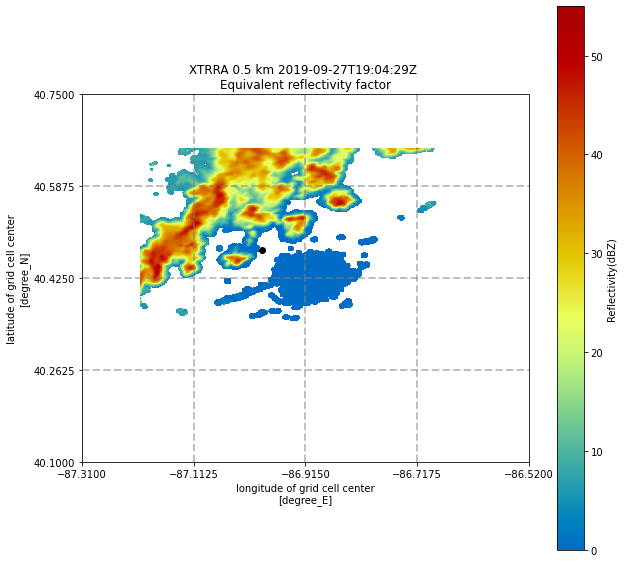

In [25]:
display = pyart.graph.GridMapDisplay(grid)

# create the plot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

#ax.imshow(grid.fields['REF']['data'][0], origin='lower')
display.plot_grid('reflectivity', 0, vmin=0, vmax=55, projection=projection, cmap="pyart_HomeyerRainbow", ax=ax)
#plt.xlim(-86.7, -85.3)
#plt.ylim(34.0, 36.0)
#start_time = '2017-04-30T20:45'
#end_time = '2017-04-30T20:45'
#plt.title('HTX Time {}'.format(start_time))

# Read in the file, create a RadarMapDisplay object
# fmcw_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'

# Indicate the PIPS location with a point
PIPS_lat = 40.47489
PIPS_lon = -86.99165
ax.plot([PIPS_lon], [PIPS_lat], color='black', marker='o', transform=ccrs.PlateCarree())


In [ ]:
# Create gridded radar objects and dump to disk
for i, radar_obj in enumerate(radar_dict['radarsweeplist']):
    print("On file {:d} of {:d} ({:.2f}%)".format(i+1, len(radar_dict['radarsweeplist']), 
                                                  (i+1)/len(radar_dict['radarsweeplist'])*100.))

    radar = pyart.io.read_nexrad_archive(f)
    output_file = os.path.basename(f)[:-5]+"_gridded.nc"
    output_path = os.path.join(gridded_output_dir, output_file)
    
    print("Mapping to grid!")
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
        fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
        weighting_function='Barnes2')
    print("Writing {}".format(output_file))
    pyart.io.write_grid(output_path, grid, arm_time_variables=True, arm_alt_lat_lon_variables=True, 
                        write_point_x_y_z=True, write_point_lon_lat_alt=True)